# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Read In Data

In [2]:
df = pd.read_csv('data_points.csv', index_col='Unnamed: 0')

df.head()

,Cx,Cy,bh,bw,wx,wy,wz
0,2305.605664,1943.493929,0.078895,0.099034,4.52848,4.30038,16.8496
1,2148.141099,1883.795226,0.057394,0.052268,5.20654,5.95728,25.9767
2,572.992103,1827.980749,0.073389,0.115642,-11.77050,4.99817,24.3663
3,1007.876193,1792.063284,0.036662,0.048362,-10.37420,6.68040,35.2435
4,1218.411586,1777.427559,0.024459,0.028799,-13.83580,12.48640,68.1562


Note: `Cx` and `Cy` are the pixel coordinates of the center of the bounding box obtained from YOLO, `bh` and `bw` are the height and width of the bounding box, and `wx`, `wy`, and `wz` are the real-world coordinates of the car in the image.

The idea is simple: Fit a model such that `wx`, `wy`, and `wz` can be predicted from the other four columns. In other words, we want to be able to derive real-world positioning of a car given a two-dimensional image. However, our process involves *no* images at all, merely relying on data obtained by other object detection methods (again, YOLO in this case) to make our predictions.

By the way, it would be a rather simple task to add roll, pitch, and yaw statistics for every row in this dataset, as the Baidu set (from which this dataframe is derived) contains that information. For now, however, we'll just work with data we have. Perhaps these will be added in a later update.

It's worth mentioning, especially as it will be used later, the dimensions of each image within the original dataset.

In [3]:
image_width = 3384
image_height = 2710

## Exploration

In [4]:
raw_count = len(df)

raw_count

20670

In [5]:
ProfileReport(df)

Number of variables,7
Number of observations,20670
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,64.0 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


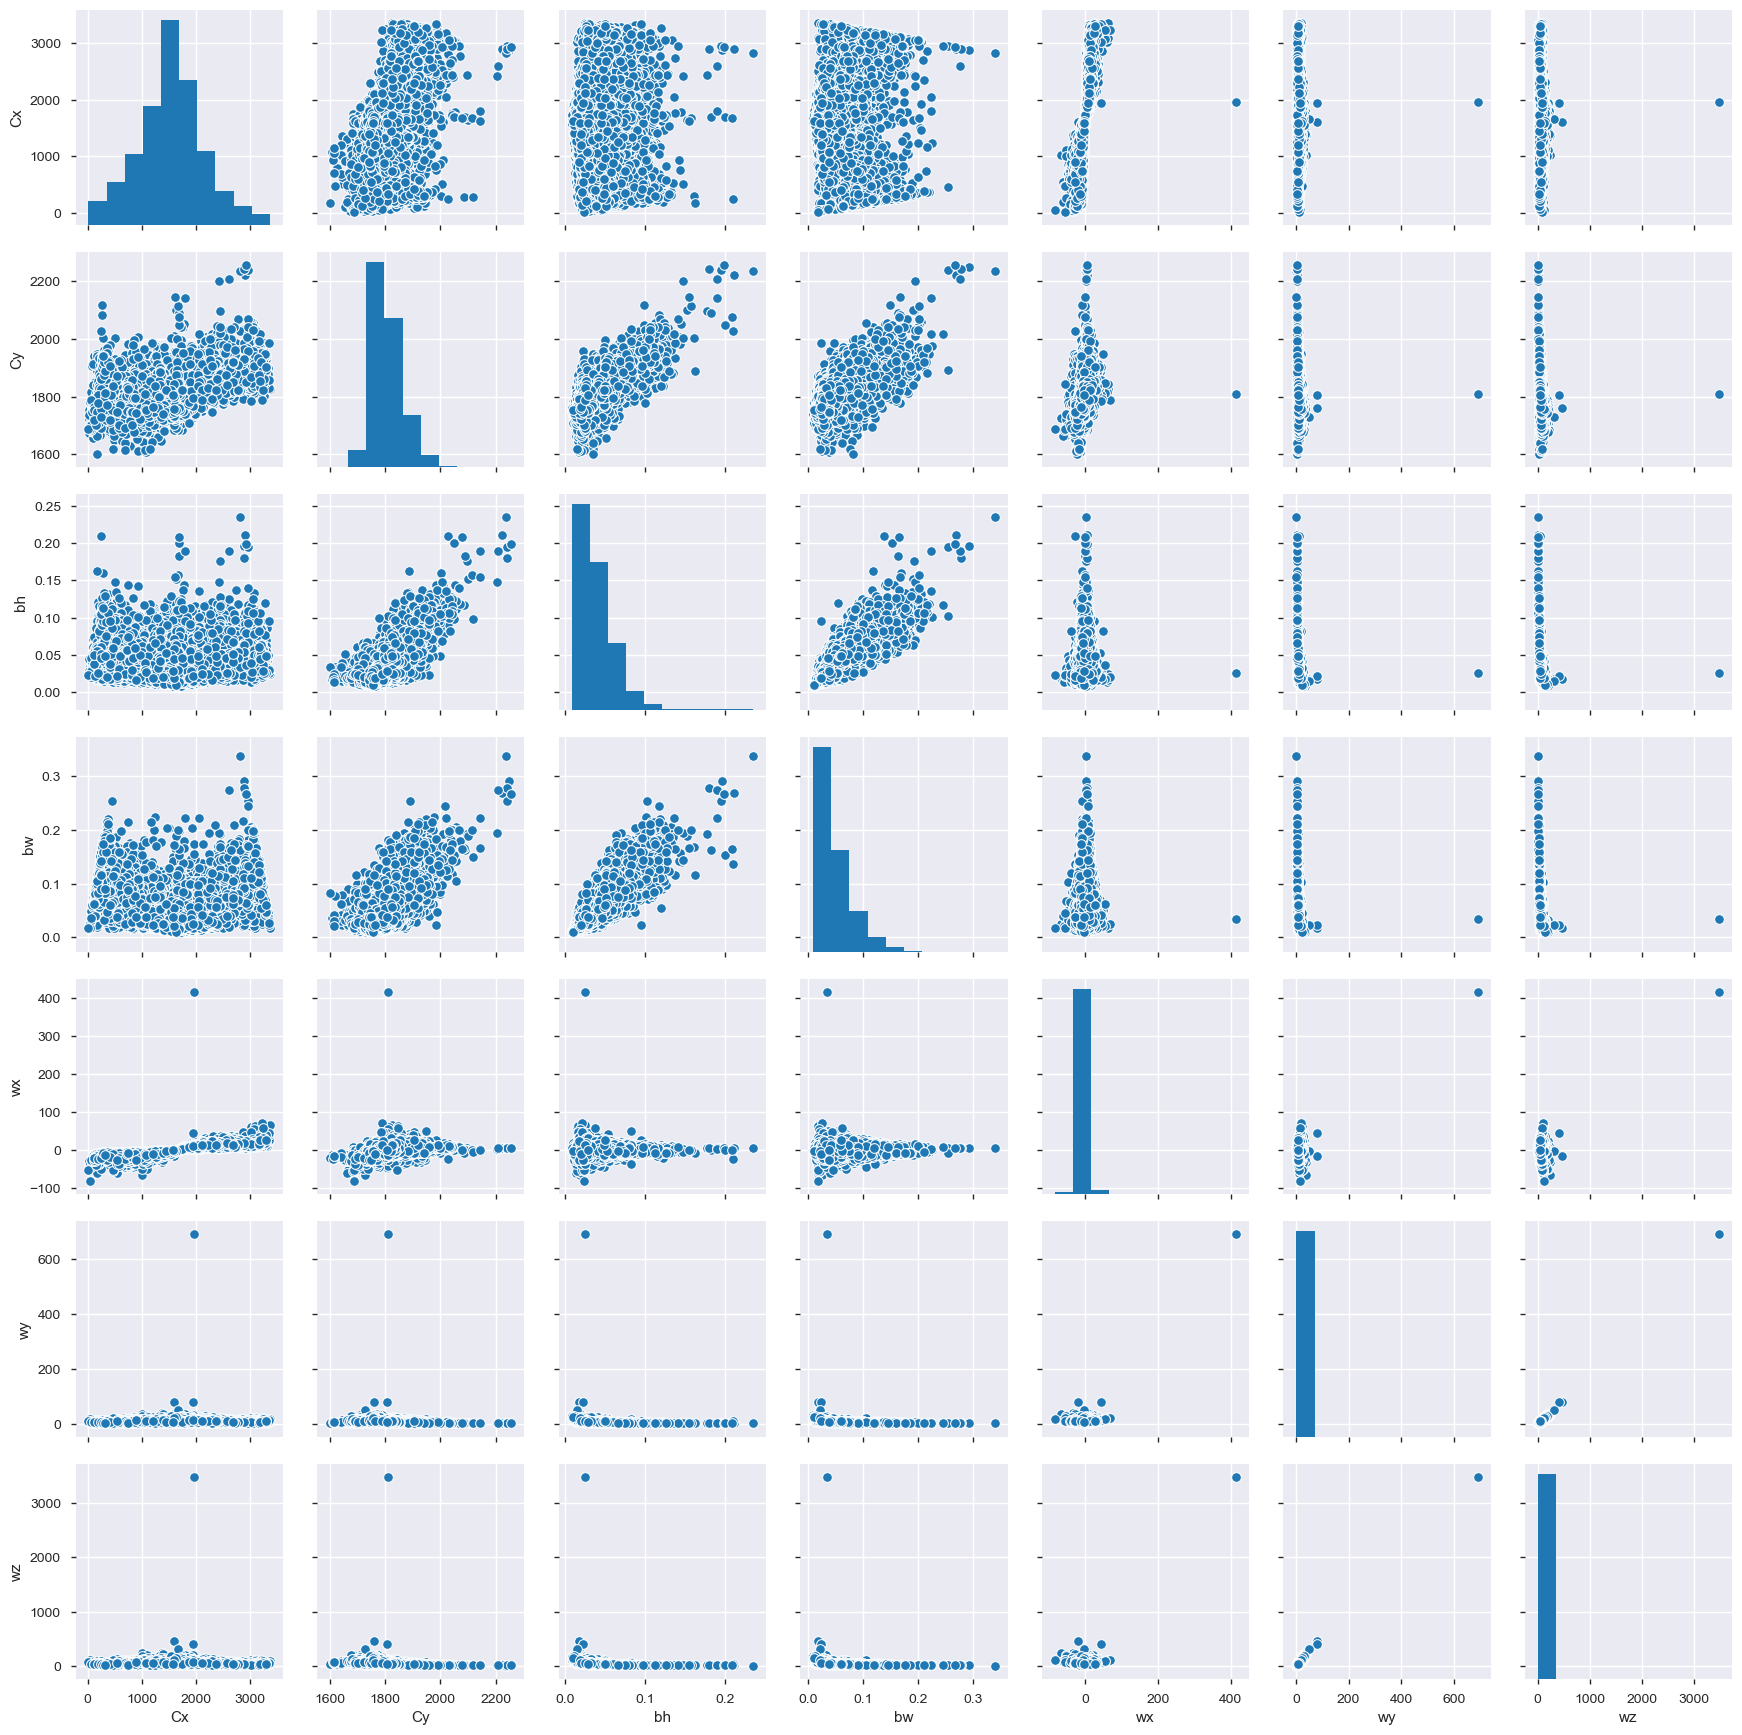

In [6]:
sns.pairplot(df);

## Preprocessing

Interestingly enough, `wy` and `wz` are extremely highly correlated. This makes sense, as a vehicle that has a "higher" vertical position within the image would be closer to the horizon in the real world. We humans correctly perceive this as a difference in depth (i.e. a difference in placement along the z-axis) without even thinking about it. 

Anyway, let's eliminate any outliers within the wx, wy, and wz columns. We'll do this using Z-score after getting rid of any extremely clear outliers.

In [7]:
df.describe().round(3)

,Cx,Cy,bh,bw,wx,wy,wz
count,20670.000,20670.000,20670.000,20670.000,20670.000,20670.000,20670.000
mean,1546.237,1806.786,0.038,0.048,-3.057,9.235,49.181
std,602.399,55.980,0.021,0.031,11.103,6.276,35.048
min,17.118,1601.442,0.008,0.009,-82.583,2.314,6.055
25%,1182.938,1767.180,0.023,0.026,-9.338,6.216,30.150
50%,1571.542,1796.707,0.032,0.038,-2.924,8.298,43.515
75%,1895.014,1837.154,0.050,0.063,3.859,11.155,61.467
max,3361.982,2256.095,0.235,0.338,414.744,689.119,3486.530


In [8]:
df['wx'].sort_values(ascending=False)

20396    414.7440
9204      69.8289
4014      64.4422
7039      63.0355
4734      60.5231
           ...   
11692    -58.5200
16155    -60.6280
9612     -61.2112
11117    -66.9460
17816    -82.5828
Name: wx, Length: 20670, dtype: float64

In [9]:
df['wy'].sort_values(ascending=False)

20396    689.11900
4831      81.14640
13500     79.34410
19907     49.48190
11678     39.52360
           ...    
10569      2.75380
18115      2.74129
11638      2.70685
16902      2.62030
2102       2.31420
Name: wy, Length: 20670, dtype: float64

In [10]:
df['wz'].sort_values(ascending=False)

20396    3486.53000
4831      462.21500
13500     404.70600
19907     305.89200
11678     241.62500
            ...    
15782       8.25648
16902       7.65450
1363        7.56639
10569       7.45693
2102        6.05523
Name: wz, Length: 20670, dtype: float64

Row 20,396 is a very clear outlier, so let's go ahead and drop it.

In [11]:
df.drop(df[df['wz'] > 500].index, inplace=True)

df.describe().round(3)

,Cx,Cy,bh,bw,wx,wy,wz
count,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000
mean,1546.217,1806.786,0.038,0.048,-3.077,9.202,49.015
std,602.406,55.981,0.021,0.031,10.716,4.126,25.626
min,17.118,1601.442,0.008,0.009,-82.583,2.314,6.055
25%,1182.894,1767.178,0.023,0.026,-9.338,6.216,30.150
50%,1571.530,1796.706,0.032,0.038,-2.925,8.297,43.514
75%,1894.929,1837.157,0.050,0.063,3.857,11.155,61.467
max,3361.982,2256.095,0.235,0.338,69.829,81.146,462.215


In the next step, we'll scale our target variables to Z-score, along with `Cx` and `Cy` according to image height and width (which we defined earlier). `bh` and `bw` are already scaled this way, so those columns remain untouched.

In [12]:
scaler = StandardScaler()
cols = ['wx','wy','wz']

df[['wx_scaled','wy_scaled','wz_scaled']] = df[cols]
df[['wx_scaled','wy_scaled','wz_scaled']] = scaler.fit_transform(df[cols].values)

df.describe().round(3)

,Cx,Cy,bh,bw,wx,wy,wz,wx_scaled,wy_scaled,wz_scaled
count,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000,20669.000
mean,1546.217,1806.786,0.038,0.048,-3.077,9.202,49.015,-0.000,-0.000,0.000
std,602.406,55.981,0.021,0.031,10.716,4.126,25.626,1.000,1.000,1.000
min,17.118,1601.442,0.008,0.009,-82.583,2.314,6.055,-7.419,-1.669,-1.676
25%,1182.894,1767.178,0.023,0.026,-9.338,6.216,30.150,-0.584,-0.724,-0.736
50%,1571.530,1796.706,0.032,0.038,-2.925,8.297,43.514,0.014,-0.219,-0.215
75%,1894.929,1837.157,0.050,0.063,3.857,11.155,61.467,0.647,0.473,0.486
max,3361.982,2256.095,0.235,0.338,69.829,81.146,462.215,6.803,17.436,16.125


In [13]:
df.drop(df[(abs(df['wx_scaled']) > 3) |
           (abs(df['wy_scaled']) > 3) |
           (abs(df['wz_scaled']) > 3)].index, inplace=True)

df['Cx'] /= image_width
df['Cy'] /= image_height

df.describe().round(3)

,Cx,Cy,bh,bw,wx,wy,wz,wx_scaled,wy_scaled,wz_scaled
count,20186.000,20186.000,20186.000,20186.000,20186.000,20186.000,20186.000,20186.000,20186.000,20186.000
mean,0.457,0.667,0.039,0.049,-2.966,8.921,47.283,0.010,-0.068,-0.068
std,0.176,0.021,0.021,0.031,10.076,3.554,22.234,0.940,0.861,0.868
min,0.006,0.591,0.008,0.010,-35.036,2.314,6.055,-2.982,-1.669,-1.676
25%,0.350,0.653,0.023,0.026,-9.272,6.176,29.855,-0.578,-0.734,-0.748
50%,0.464,0.663,0.033,0.039,-2.889,8.185,42.789,0.018,-0.246,-0.243
75%,0.562,0.678,0.050,0.064,3.868,10.946,60.117,0.648,0.423,0.433
max,0.992,0.833,0.235,0.338,29.046,21.556,125.742,2.998,2.994,2.994


In [14]:
processed_count = len(df)

processed_count/raw_count

0.9765844218674408

We've deleted less than 3% of our data after preprocessing, which is great!

## Checking For Correlations

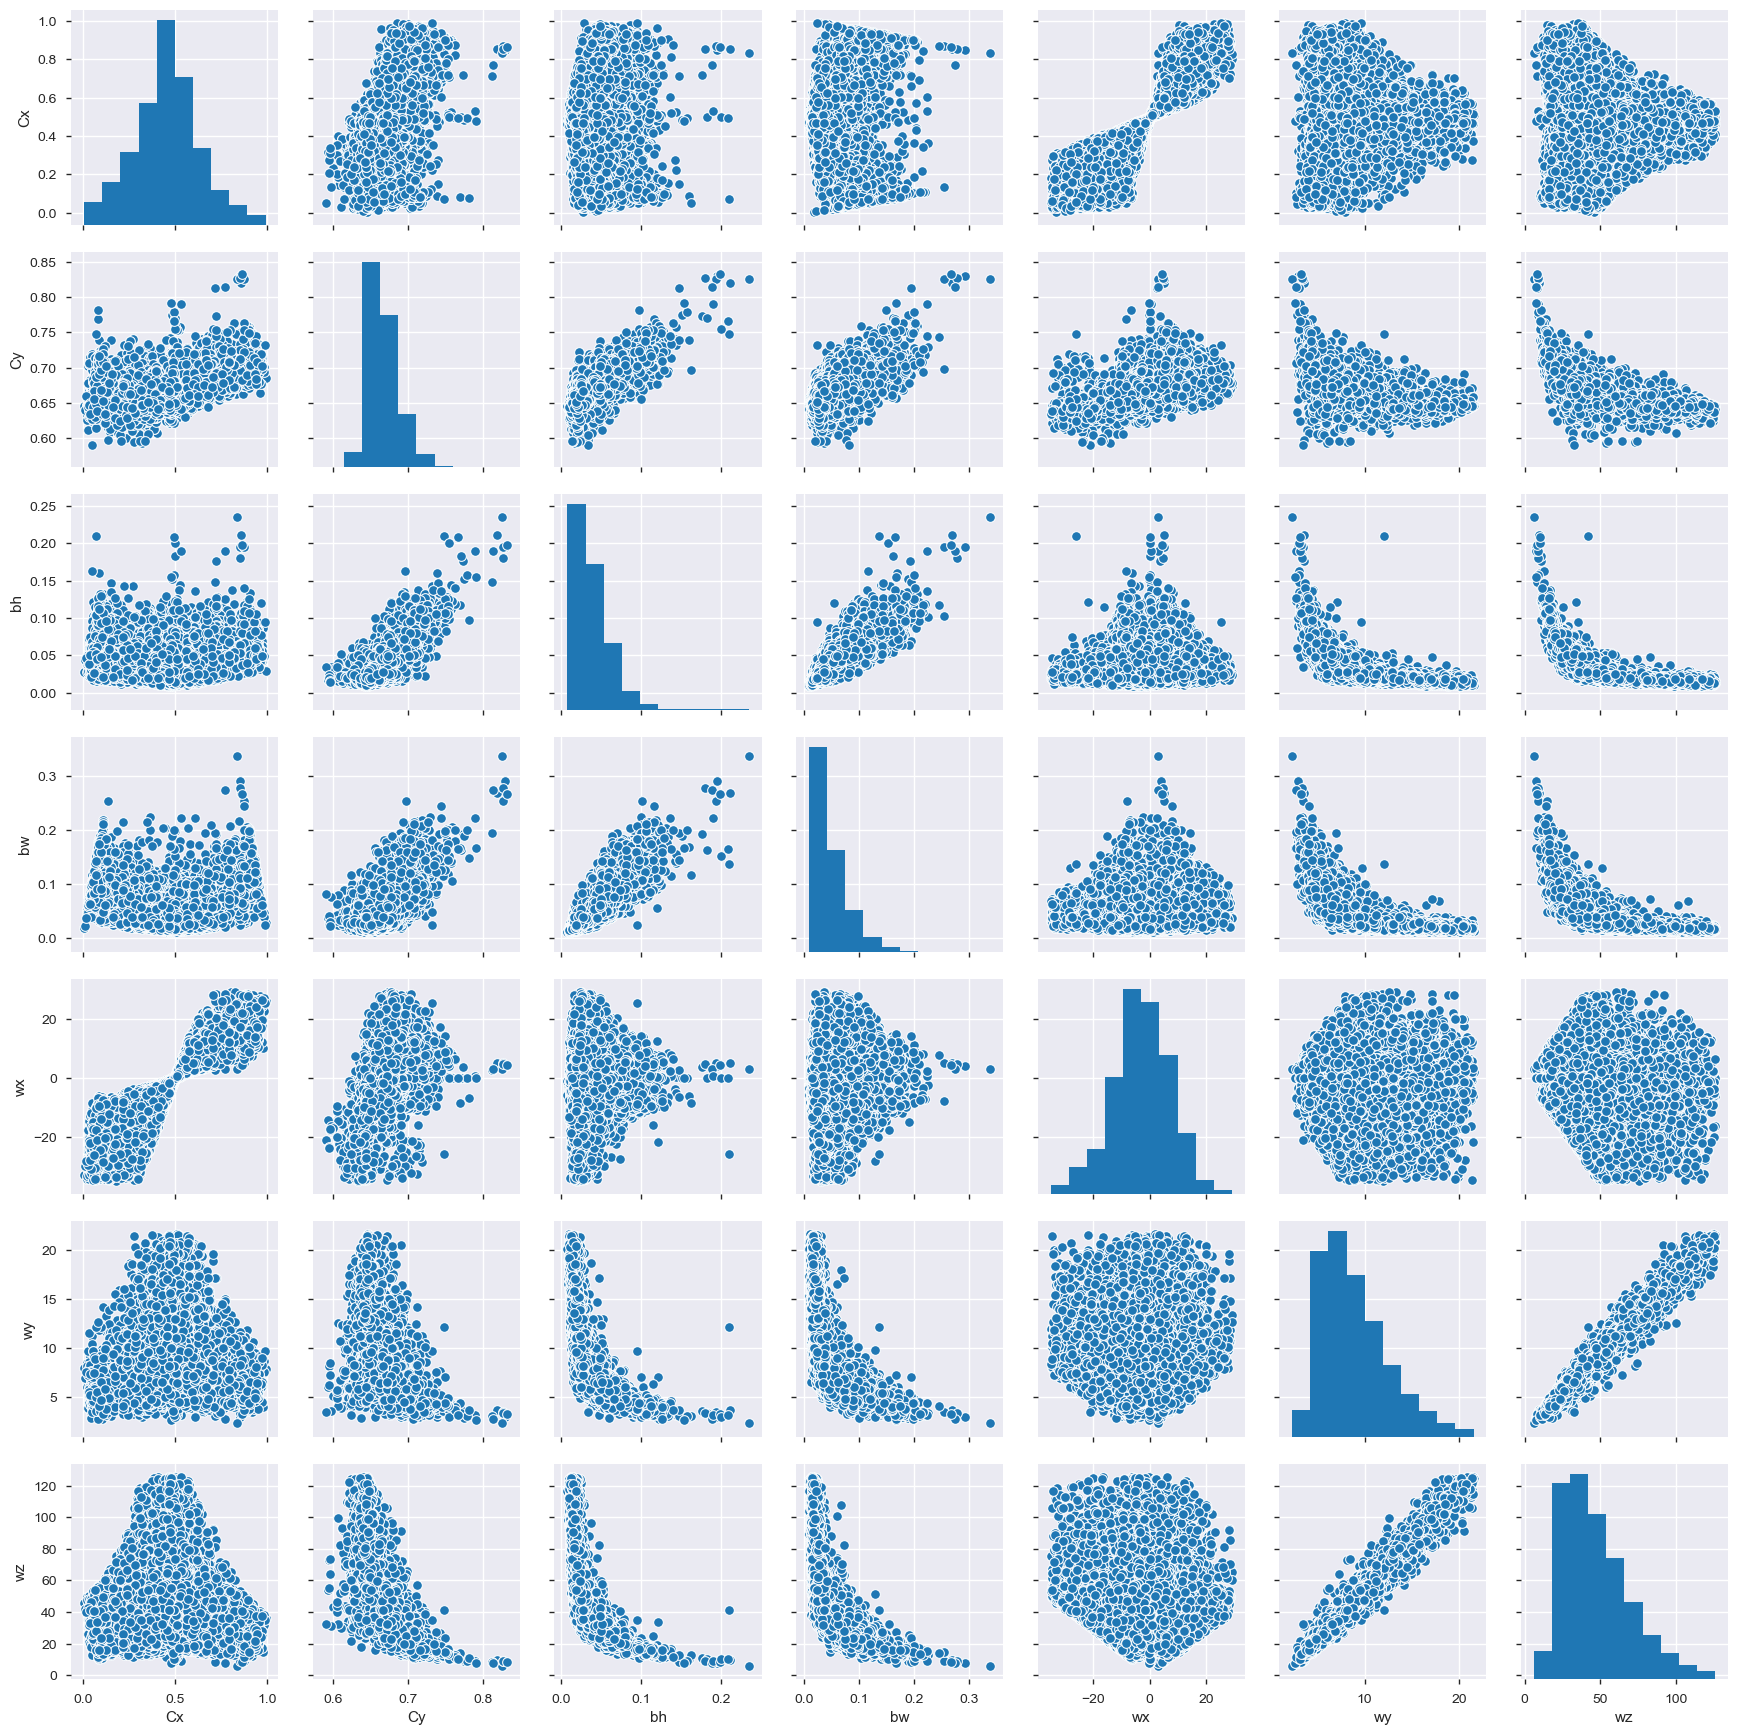

In [15]:
sns.pairplot(df.drop(['wx_scaled','wy_scaled','wz_scaled'], axis=1));

At first glance of our updated pairplot, it looks as thought we have some small correlation left between our variables. This makes sense, since boxes will only be within a range of sizes and shapes, but let's create a correlation heatmap to see what kind of logic our models will be using to make their predictions. 

Note: We don't need to worry about multicollinearity since we're not creating a linear regression model, even though we could. Perhaps in a later update, I'll add a linear regression model to showcase the extra steps we have to take in order to make one.

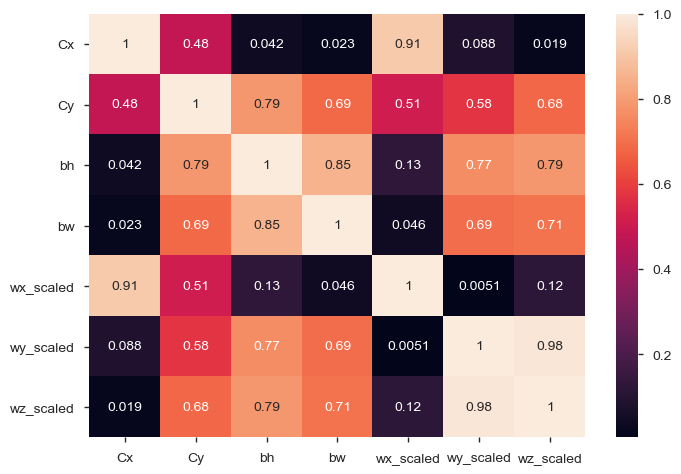

In [16]:
sns.heatmap(abs(df.drop(['wx','wy','wz'], axis=1).corr()), annot=True);

It looks like `Cx` is pretty highly correlated with `wx`, which is kind of to be expected; the further left of center the car is in the picture, for example, then the further left of center the car will be in the real world. Going by this point alone, we can expect that our models will be able to predict `wx` with more certainty and less error than `wy` or `wz`.

Additionally, `bh` and `bw` are highly correlated, but that's okay, too; we can expect most of the bounding boxes to be vaguely rectangular, so there's no point doing any further processing simply because of this fact. 

Again, `wy` and `wz` are nearly perfectly correlated, which should aid our models in prediction.

# Model Selection

It looks like we're finally ready to select a suite of models/ensembles and get to work. For no other purpose than to satisfy my own need to practice different methods, we'll be looking at the following models:

- K-Nearest Neighbors
- Boosted Random Forest (Gradient, AdaBoost, XGBoost)
- Support Vector Machines
- Neural Network

In [17]:
# Need to import MOR since we have 3 target columns
from sklearn.multioutput import MultiOutputRegressor as MOR

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              GradientBoostingRegressor)
from xgboost import XGBRegressor
from sklearn.svm import SVR

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

## Train/Test Split

We'll utilize an 80-20 train-test split for this project.

In [18]:
features = ['Cx','Cy','bh','bw']
targets = ['wx_scaled','wy_scaled','wz_scaled']

X = df[features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## KNN

In [19]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.9167875040689704
0.8755570802812445


87.5% overall accuracy isn't bad, but I'd like to dive a little deeper and see how good the accuracy is for each direction, i.e. `wx`, `wy`, and `wz`. Let's write some functions to help out with that. I would also like to implement a timer to see how quickly these models reach their conclusions, which will help us settle on a final model to tune.

In [20]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from time import perf_counter

def get_metrics(preds, test_set=y_test):
    
    """A function used to print out R2 scores for 
    each individual prediction dimension."""
    
    wx_mse = mse(test_set['wx_scaled'], preds[:, 0])
    wy_mse = mse(test_set['wy_scaled'], preds[:, 1])
    wz_mse = mse(test_set['wz_scaled'], preds[:, 2])
    
    wx_r2 = r2_score(test_set['wx_scaled'], preds[:, 0])
    wy_r2 = r2_score(test_set['wy_scaled'], preds[:, 1])
    wz_r2 = r2_score(test_set['wz_scaled'], preds[:, 2])
    
    print('WX MSE: ', wx_mse)
    print('WY MSE: ', wy_mse)
    print('WZ MSE: ', wz_mse, '\n')
    
    print('WX R-squared: ', wx_r2)
    print('WY R-squared: ', wy_r2)
    print('WZ R-squared: ', wz_r2)
    
def run_model(reg):
    
    """A function used to run/time regression models and
    print out results."""
    
    start = perf_counter()
    
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    
    print('Train R2: ', reg.score(X_train, y_train))
    print('Test R2: ', reg.score(X_test, y_test), '\n')
    
    get_metrics(preds)
    
    end = perf_counter()
    print('\nTime to run: ', round(end-start, 3), ' seconds')

In [21]:
run_model(knn)

Train R2:  0.9167875040689704
Test R2:  0.8755570802812445 

WX MSE:  0.02445609348350456
WY MSE:  0.15305807499256077
WZ MSE:  0.12205118676332705 

WX R-squared:  0.97263599507968
WY R-squared:  0.7957930462164599
WZ R-squared:  0.8402459985276707

Time to run:  0.147  seconds


## Random Forests

### Vanilla RF

In [22]:
run_model(RandomForestRegressor())

Train R2:  0.9842932747824018
Test R2:  0.8870074232550144 

WX MSE:  0.021734811960496363
WY MSE:  0.13899985054118796
WZ MSE:  0.11126684203167786 

WX R-squared:  0.9756808460913675
WY R-squared:  0.8145492418040474
WZ R-squared:  0.8543617336534488

Time to run:  4.413  seconds


### Gradient Boosted RF

In [23]:
run_model(MOR(GradientBoostingRegressor()))

Train R2:  0.8926214149805802
Test R2:  0.8817070980118819 

WX MSE:  0.02468397955524647
WY MSE:  0.1377894585499259
WZ MSE:  0.10957503282778351 

WX R-squared:  0.9723810125906482
WY R-squared:  0.8161641220475866
WZ R-squared:  0.8565761593974108

Time to run:  4.214  seconds


This one has significantly less overfitting than the vanilla forest model, with virtually no tradeoff in accuracy.

### AdaBoost

In [24]:
run_model(MOR(AdaBoostRegressor()))

Train R2:  0.812934828576617
Test R2:  0.8067013811820267 

WX MSE:  0.0938134541680555
WY MSE:  0.2041844569221009
WZ MSE:  0.15471572782593687 

WX R-squared:  0.895031811880406
WY R-squared:  0.7275812729250952
WZ R-squared:  0.797491058740579

Time to run:  1.449  seconds


### XGBoost

In [25]:
run_model(MOR(XGBRegressor(objective = 'reg:squarederror')))

Train R2:  0.8918203719837899
Test R2:  0.8814197388392465 

WX MSE:  0.02562288604123752
WY MSE:  0.13767433337520055
WZ MSE:  0.10954839200127305 

WX R-squared:  0.9713304669783774
WY R-squared:  0.8163177197015202
WZ R-squared:  0.856611029837842

Time to run:  1.002  seconds


## SVM

In [26]:
run_model(MOR(SVR(C=100)))

Train R2:  0.8626476689552747
Test R2:  0.862423689395461 

WX MSE:  0.025109743321392753
WY MSE:  0.15955950525015924
WZ MSE:  0.131217994754834 

WX R-squared:  0.971904624086508
WY R-squared:  0.7871189709139653
WZ R-squared:  0.82824747318591

Time to run:  26.96  seconds


## Neural Network

In [27]:
model = models.Sequential([
    layers.Dense(100, activation='linear', input_shape=[len(X_train.keys()),]),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(100, activation='relu'),
    layers.Dense(3, activation='linear')
])

In [28]:
model.compile(loss='mse',
              optimizer=optimizers.Adam(),
              metrics=['mae', 'mse'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 21,003
Trainable params: 21,003
Non-trainable params: 0
____________________________________________________

In [30]:
history = model.fit(x=X_train.values,
                    y=y_train.values,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=32)

Train on 12918 samples, validate on 3230 samples
Epoch 1/10
12918/12918 [==============================] - 1s 107us/sample - loss: 0.3096 - mae: 0.3933 - mse: 0.3096 - val_loss: 0.1188 - val_mae: 0.2174 - val_mse: 0.1188
Epoch 2/10
12918/12918 [==============================] - 1s 81us/sample - loss: 0.1336 - mae: 0.2502 - mse: 0.1336 - val_loss: 0.1010 - val_mae: 0.2083 - val_mse: 0.1010
Epoch 3/10
12918/12918 [==============================] - 1s 89us/sample - loss: 0.1238 - mae: 0.2379 - mse: 0.1238 - val_loss: 0.0975 - val_mae: 0.1999 - val_mse: 0.0975
Epoch 4/10
12918/12918 [==============================] - 1s 71us/sample - loss: 0.1189 - mae: 0.2318 - mse: 0.1189 - val_loss: 0.0978 - val_mae: 0.2005 - val_mse: 0.0978
Epoch 5/10
12918/12918 [==============================] - 1s 73us/sample - loss: 0.1150 - mae: 0.2279 - mse: 0.1150 - val_loss: 0.0943 - val_mae: 0.1976 - val_mse: 0.0943
Epoch 6/10
12918/12918 [==============================] - 1s 72us/sample - loss: 0.1138 - mae: 

In [31]:
preds = model.predict(X_test.values)

In [32]:
get_metrics(preds)

WX MSE:  0.030267081714062543
WY MSE:  0.1530669670861589
WZ MSE:  0.13679297665252385 

WX R-squared:  0.9661340608831919
WY R-squared:  0.7957811825670149
WZ R-squared:  0.8209503244247202


# Hyperparameter Tuning

Looks like we'll pick XGBoost for hyperparameter tuning, as it has high accuracy with very low runtime. 

In [33]:
from sklearn.model_selection import GridSearchCV

# using gridsearch with multioutput regressors requires use of the
# estimator__ call when writing the parameter dictionary

param_grid = {
    'estimator__n_estimators': [100, 200, 400, 500, 1000],
    'estimator__max_depth': [2, 3, 4, 5],
    'estimator__learning_rate': [0.1, 0.01]
}

In [34]:
xgmodel = MOR(XGBRegressor(objective = 'reg:squarederror'))

gridsearch = GridSearchCV(xgmodel, param_grid=param_grid)

In [35]:
run_model(gridsearch)

Train R2:  0.9086032775478011
Test R2:  0.8865482882332669 

WX MSE:  0.02041752839098443
WY MSE:  0.13342345592708668
WZ MSE:  0.10657651255297175 

WX R-squared:  0.9771547590898557
WY R-squared:  0.821989153466963
WZ R-squared:  0.8605009521429823

Time to run:  778.055  seconds


In [36]:
gridsearch.best_params_

{'estimator__learning_rate': 0.01,
 'estimator__max_depth': 5,
 'estimator__n_estimators': 1000}

Let's check the runtime of the best parameters.

In [37]:
xgmodel_1 = MOR(XGBRegressor(learning_rate = 0.01,
                             max_depth = 5,
                             n_estimators = 1000,
                             objective = 'reg:squarederror'))

run_model(xgmodel_1)

Train R2:  0.9086032775478011
Test R2:  0.8865482882332669 

WX MSE:  0.02041752839098443
WY MSE:  0.13342345592708668
WZ MSE:  0.10657651255297175 

WX R-squared:  0.9771547590898557
WY R-squared:  0.821989153466963
WZ R-squared:  0.8605009521429823

Time to run:  16.688  seconds


Looks like we upped our test accuracy by about half a percent across the board. More importantly, however, is that the set of values deemed to be "best" by the gridsearch are all the maximum values that were listed as options in our parameter dictionary. This is no surprise, of course; a forest of grand oaks will generally do better than a small field of saplings, and a smaller learning rate will allow for a more fine-tuned model.

The downside here is the time to run. If it takes an extra 15 seconds to achieve an increase of 0.5%, we should be left wondering if that half a percent is worth it at all. The "best" model, therefore, is probably somewhere in the middle; an increase of 0.25% would be worth it if it only added an extra second to our model time. 